# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

In [10]:
data

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"
...,...,...,...,...,...,...
5386,2950,10/8/2018,Meg,"$15,000,000",$0,$0
5387,126,12/18/2018,Aquaman,"$160,000,000",$0,$0
5388,96,12/31/2020,Singularity,"$175,000,000",$0,$0
5389,1119,12/31/2020,Hannibal the Conqueror,"$50,000,000",$0,$0


# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
data.shape
data.isna().values.sum()

(5391, 6)

In [9]:
data.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
5386    False
5387    False
5388    False
5389    False
5390    False
Length: 5391, dtype: bool

### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [14]:
data.USD_Domestic_Gross = data.USD_Domestic_Gross.astype(str).str.replace('$',"")
data.USD_Domestic_Gross = data.USD_Domestic_Gross.astype(str).str.replace(",",'')
data.USD_Domestic_Gross = pd.to_numeric(data.USD_Domestic_Gross)
data.USD_Production_Budget = data.USD_Production_Budget.astype(str).str.replace('$',"")
data.USD_Production_Budget = data.USD_Production_Budget.astype(str).str.replace(",",'')
data.USD_Production_Budget = pd.to_numeric(data.USD_Production_Budget)
data.USD_Worldwide_Gross = data.USD_Worldwide_Gross.astype(str).str.replace('$',"")
data.USD_Worldwide_Gross = data.USD_Worldwide_Gross.astype(str).str.replace(",",'')
data.USD_Worldwide_Gross = pd.to_numeric(data.USD_Worldwide_Gross)
data

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,110000,11000000,10000000
1,5140,5/9/1916,Intolerance,385907,0,0
2,5230,12/24/1916,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,9/17/1920,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1/1/1925,The Big Parade,245000,22000000,11000000
...,...,...,...,...,...,...
5386,2950,10/8/2018,Meg,15000000,0,0
5387,126,12/18/2018,Aquaman,160000000,0,0
5388,96,12/31/2020,Singularity,175000000,0,0
5389,1119,12/31/2020,Hannibal the Conqueror,50000000,0,0


'Avatar'

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [15]:
data.Release_Date = pd.to_datetime(data.Release_Date)
data.Release_Date.head()

0   1915-08-02
1   1916-05-09
2   1916-12-24
3   1920-09-17
4   1925-01-01
Name: Release_Date, dtype: datetime64[ns]

### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [32]:
print(f"the average production budget of the films in the data set: ${data.USD_Production_Budget.mean()}")
print(f'the average worldwide gross revenue of films: ${data.USD_Worldwide_Gross.mean()}')
print(f'the minimums for worldwide and domestic revenue: worldwide :${data.USD_Worldwide_Gross.min()}, domestic: ${data.USD_Domestic_Gross.min()}')
print(f'the highest production budget:{data.Movie_Title[data.USD_Production_Budget.idxmax()]} - ${data.USD_Production_Budget.max()}')
print(f'the highest worldwide gross revenue: {data.Movie_Title[data.USD_Worldwide_Gross.idxmax()]} - ${data.USD_Worldwide_Gross.max()}')
print(f'the lowest budget films make: {data.Movie_Title[data.USD_Production_Budget.idxmin()]} - ${data.USD_Domestic_Gross[data.USD_Production_Budget.idxmin()] + data.USD_Worldwide_Gross[data.USD_Production_Budget.idxmin()]}')
print(f'the highest budget films make: {data.Movie_Title[data.USD_Production_Budget.idxmax()]} - ${data.USD_Domestic_Gross[data.USD_Production_Budget.idxmax()] + data.USD_Worldwide_Gross[data.USD_Production_Budget.idxmax()]}')

the average production budget of the films in the data set: $31113737.57837136
the average worldwide gross revenue of films: $88855421.96271564
the minimums for worldwide and domestic revenue: worldwide :$0, domestic: $0
the highest production budget:Avatar - $425000000
the highest worldwide gross revenue: Avatar - $2783918982
the lowest budget films make: My Date With Drew - $362082
the highest budget films make: Avatar - $3544426607


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [36]:
data_zero_domestic = data[data.USD_Domestic_Gross == 0]
data_zero_domestic.sort_values(by='USD_Production_Budget',ascending=False).head()


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [38]:
data_zero_worldwide = data[data.USD_Worldwide_Gross == 0]
data_zero_worldwide.sort_values(by='USD_Production_Budget',ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0


### Filtering on Multiple Conditions

In [48]:
international_releases = data.loc[(data.USD_Worldwide_Gross != 0) & (data.USD_Domestic_Gross == 0)]
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [46]:
worldwide_gross_revenue = data.query('USD_Worldwide_Gross == 0 and USD_Domestic_Gross != 0')
worldwide_gross_revenue

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [49]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [51]:
future_relases = data[data.Release_Date >= scrape_date]
future_relases

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5386,2950,2018-10-08,Meg,15000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5388,96,2020-12-31,Singularity,175000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0


In [78]:
data_clean = data.drop(future_relases.index)
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000
...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [56]:
movie_lossing = data_clean[data_clean.USD_Production_Budget > data_clean.USD_Worldwide_Gross]
len(movie_lossing)/len(data_clean) * 100

37.27711738484398

# Seaborn for Data Viz: Bubble Charts

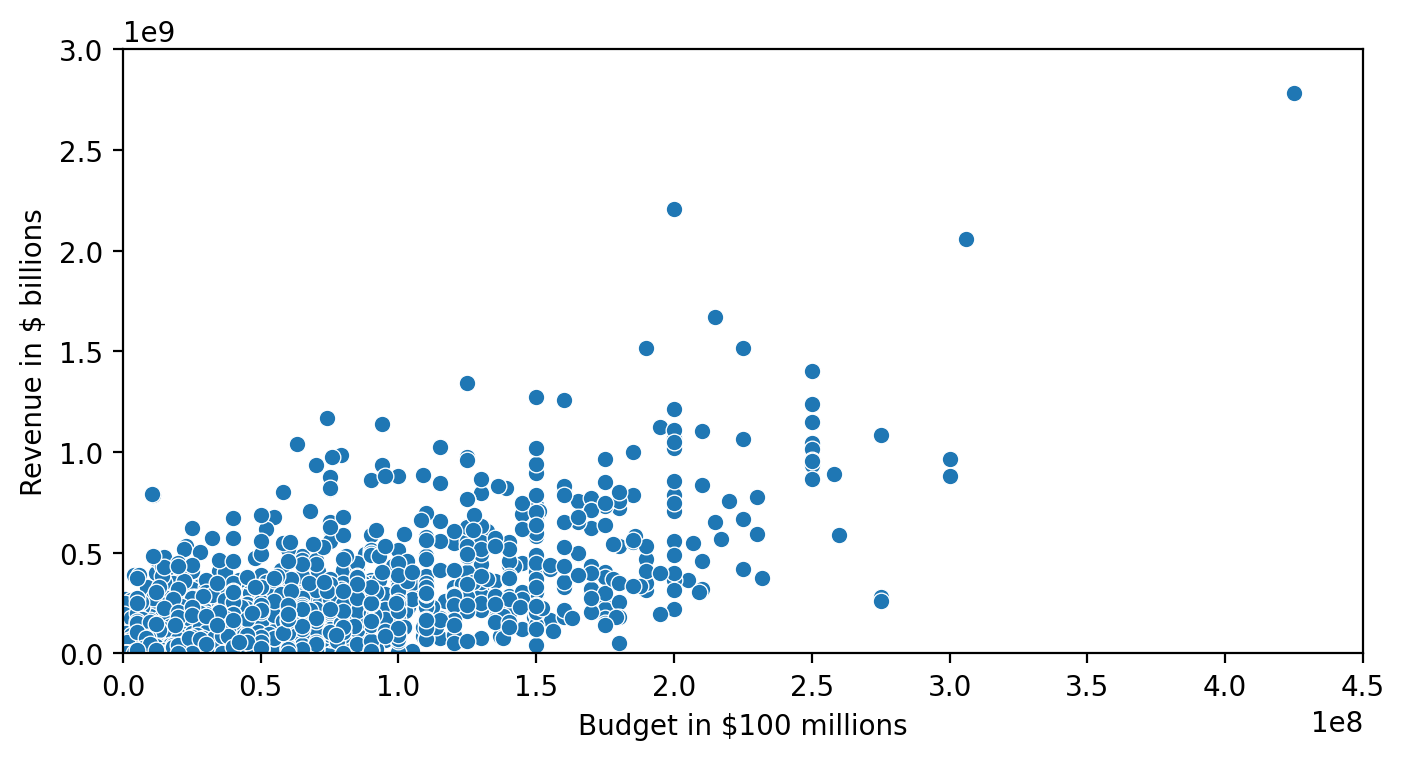

In [61]:
plt.figure(figsize=(8,4),dpi=200)
ax = sns.scatterplot(data=data_clean,x='USD_Production_Budget',y='USD_Worldwide_Gross')
ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions')
plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



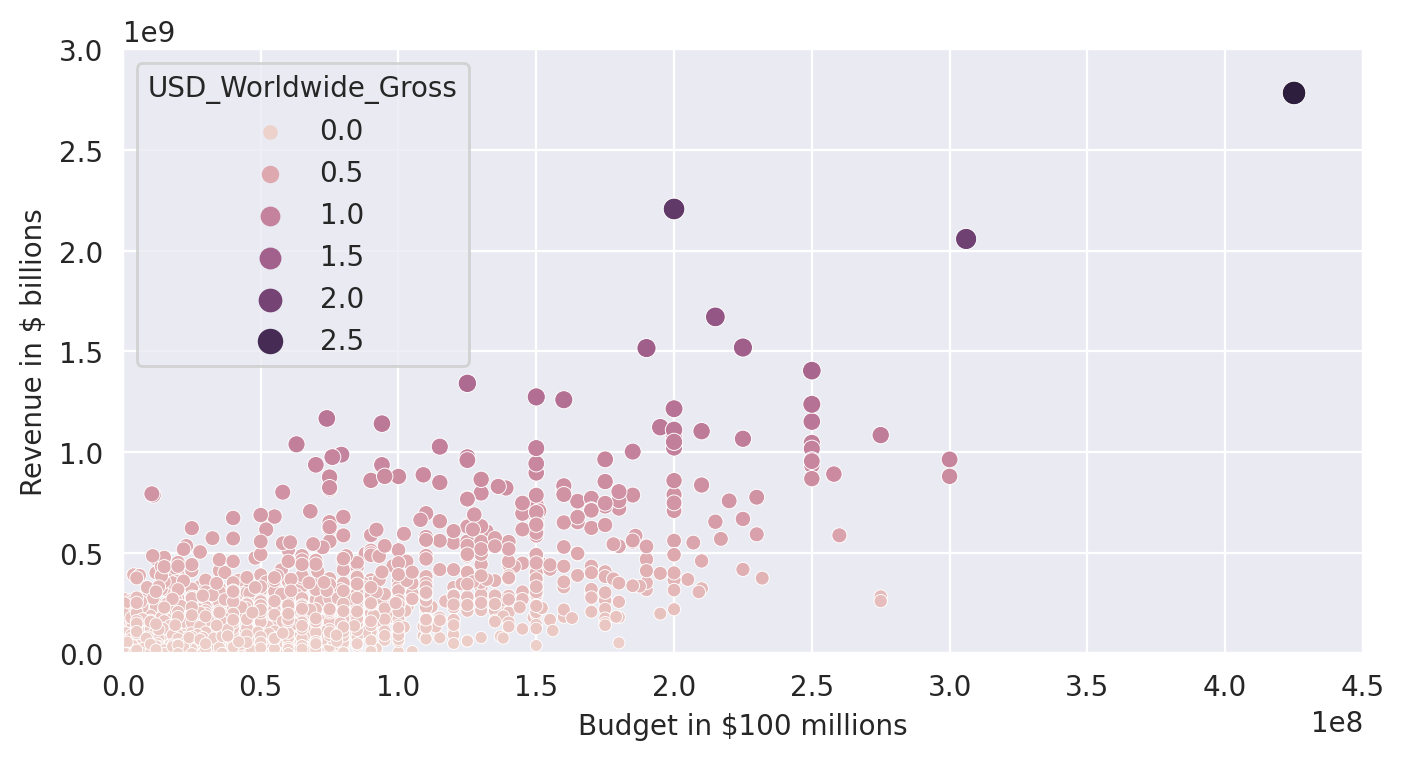

In [63]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(8,4),dpi=200)
  ax1 = sns.scatterplot(data=data_clean,
                        x='USD_Production_Budget',
                        y='USD_Worldwide_Gross',
                        hue='USD_Worldwide_Gross',
                        size='USD_Worldwide_Gross')
  ax1.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')
  plt.show()

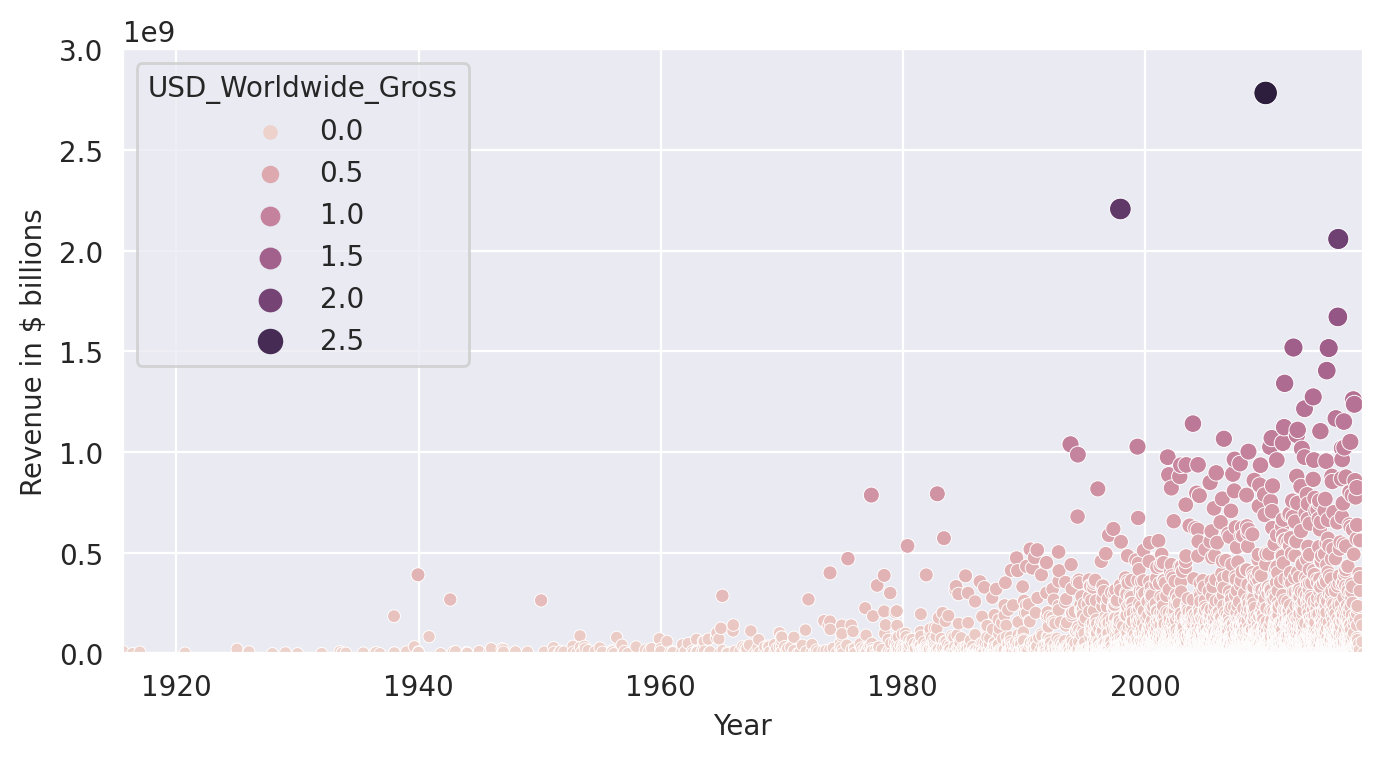

In [66]:
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(8,4),dpi=200)
  ax1 = sns.scatterplot(data=data_clean,
                        x='Release_Date',
                        y='USD_Worldwide_Gross',
                        hue='USD_Worldwide_Gross',
                        size='USD_Worldwide_Gross')
  ax1.set(ylim=(0, 3000000000),
          xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
        ylabel='Revenue in $ billions',
        xlabel='Year')
  plt.show()

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [90]:
data_year = pd.DatetimeIndex(data_clean.Release_Date).year
data_clean['Decade'] = data_year // 10 * 10


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [105]:
old_films = data_clean[data_clean.Decade < 1970]
new_films = data_clean[data_clean.Decade > 1970]
print(old_films.shape,new_films.shape)
print(f'the most expensive film made prior to 1970: {old_films.Movie_Title[old_films.USD_Production_Budget.idxmax()]}- ${old_films.USD_Production_Budget.max()}')



(153, 7) (5122, 7)
the most expensive film made prior to 1970: Cleopatra- $42000000


# Seaborn Regression Plots

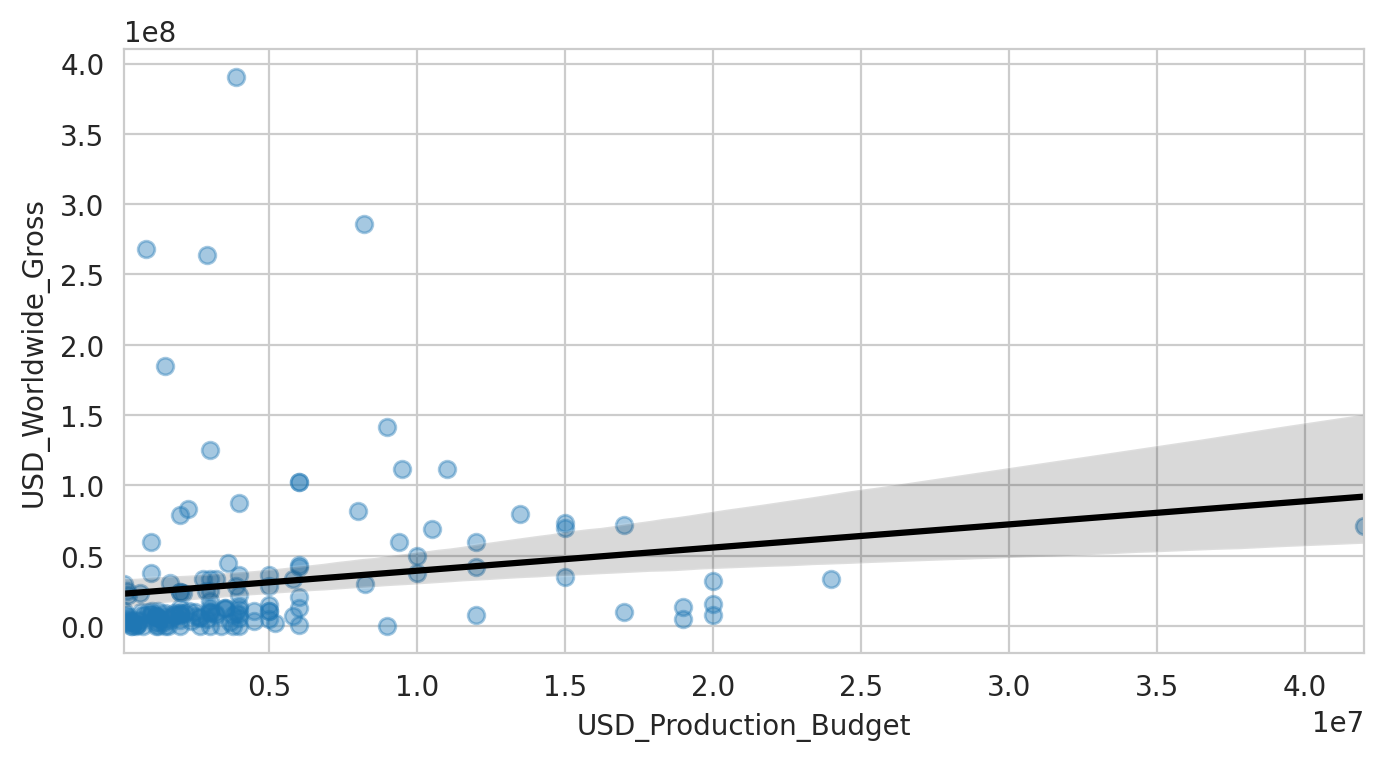

In [108]:
plt.figure(figsize=(8,4),dpi=200)
with sns.axes_style('whitegrid'):
  ax = sns.regplot(data=old_films,
              x='USD_Production_Budget',
              y='USD_Worldwide_Gross',
              scatter_kws = { 'alpha' : 0.4 },  
              line_kws = { 'color' : 'black' })
plt.show()

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

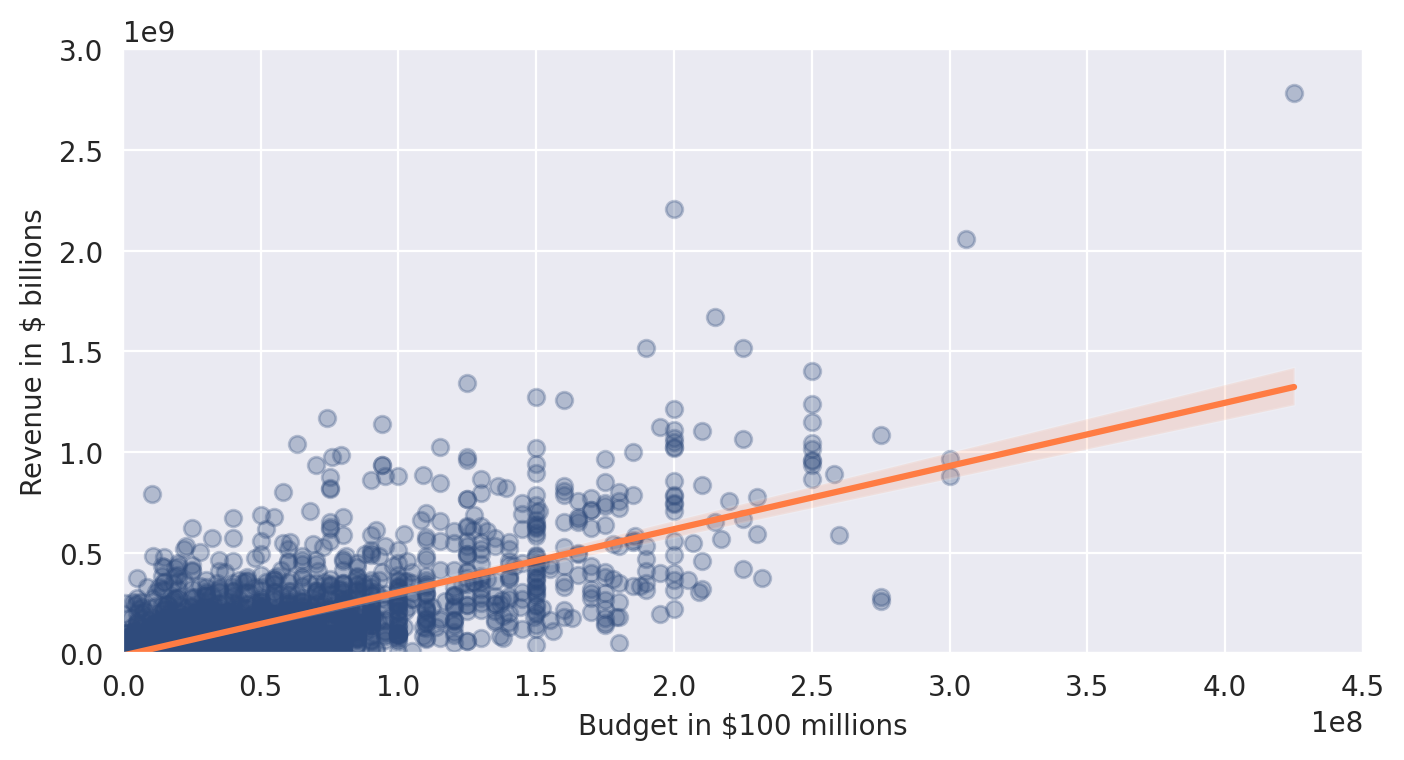

In [112]:
plt.figure(figsize=(8,4),dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.regplot(data=new_films,
                   x='USD_Production_Budget',
                   y='USD_Worldwide_Gross',
                   color='#2f4b7c',
                   scatter_kws = {'alpha': 0.3},
                   line_kws = {'color': '#ff7c43'})
  ax.set(ylim=(0, 3000000000),
         xlim=(0, 450000000),
         ylabel='Revenue in $ billions',
         xlabel='Budget in $100 millions')
plt.show()

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [123]:
regression = LinearRegression()
X = pd.DataFrame(new_films,columns=['USD_Production_Budget'])
y = pd.DataFrame(new_films,columns=['USD_Worldwide_Gross'])
regression.fit(X,y)
print(regression.coef_)
print(regression.intercept_)
print(regression.score(X,y))

[[3.13834648]]
[-10278584.79397978]
0.564250171393927


**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [124]:
X1 = pd.DataFrame(old_films,columns=['USD_Production_Budget'])
y1 = pd.DataFrame(old_films,columns=['USD_Worldwide_Gross'])
regression.fit(X1,y1)
print(regression.coef_)
print(regression.intercept_)
print(regression.score(X1,y1))

[[1.64771314]]
[22821538.63508039]
0.02937258620576877


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [128]:
budget = 350000000

In [130]:
revernu = regression.intercept_[0] + regression.coef_[0,0] * budget
print(f'The global revenue does our model estimate for a film with a budget of $350 million: ${int(revernu)}')

The global revenue does our model estimate for a film with a budget of $350 million: $599521139
